In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Import Visual transformer model from https://huggingface.co/google/vit-base-patch16-224

In [2]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

Make your custom dataset compatible with PyTorch's data loading utilities.

In [3]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

Define data transformmations

In [4]:

# Define data transforms (you can modify these based on your needs)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize pixel values
])

# Define paths to your data folders
train_data_dir = "/data/Desktop/trainset/"
val_data_dir = "/data/Desktop/validation/"
test_data_dir = "/data/Desktop/testset/"

# Load your training, validation, and test datasets using ImageFolder
train_dataset = ImageFolder(root=train_data_dir, transform=transform)
val_dataset = ImageFolder(root=val_data_dir, transform=transform)
test_dataset = ImageFolder(root=test_data_dir, transform=transform)

# If you want to access the labels for train, validation, and test datasets:
train_labels = train_dataset.targets
val_labels = val_dataset.targets
test_labels = test_dataset.targets

# Create data loaders
batch_size = 8  # Adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
# Define a binary classification head
class BinaryClassificationHead(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BinaryClassificationHead, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Modify the Swin Transformer model for binary classification
classifier_head = BinaryClassificationHead(768, 32)  # Adjust input size as needed
model.classifier = classifier_head

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)


Epoch 1, Training Loss: 0.16330342032015324, Validation Loss: 0.04277569330297411
Epoch 2, Training Loss: 0.011719696029710272, Validation Loss: 0.010339074426641066
Epoch 3, Training Loss: 0.005349896700742344, Validation Loss: 0.005018772509518183
Epoch 4, Training Loss: 0.0035430949549966804, Validation Loss: 0.003699443979550981
Epoch 5, Training Loss: 0.002370276707612599, Validation Loss: 0.0028005061858695827
Epoch 6, Training Loss: 0.0016456132395736252, Validation Loss: 0.0024571664734847017
Epoch 7, Training Loss: 0.0012216319873308143, Validation Loss: 0.002187821517388026
Epoch 8, Training Loss: 0.0009606858288558821, Validation Loss: 0.0020566647788251026
Epoch 9, Training Loss: 0.000777412820510411, Validation Loss: 0.0020506692982356373
Early stopping at epoch 9


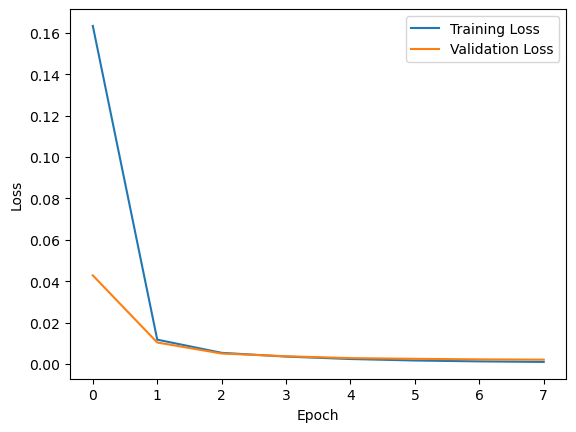

In [6]:
# Assuming model, train_loader, val_loader, criterion, and optimizer are defined

num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize early stopping parameters
patience = 5
verbose = True
delta = 0.001  # Set an appropriate delta value
best_val_loss = float('inf')
counter = 0

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data).logits
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_data, val_labels in val_loader:
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            val_outputs = model(val_data).logits
            val_loss += criterion(val_outputs, val_labels.unsqueeze(1).float()).item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

    # Early stopping
    if avg_val_loss < best_val_loss - delta:
        best_val_loss = avg_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch+1}")
            break

    # Save the model if validation loss is improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Append losses for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

# Plotting the training and validation curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
# Validation set for EER calculation
model.eval()
val_labels, val_scores = [], []

with torch.no_grad():
    for data, labels in val_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data).logits
        val_labels.extend(labels.cpu().numpy())
        val_scores.extend(torch.sigmoid(outputs).cpu().numpy())


# Calculate Equal Error Rate (EER) on the validation set
fpr, tpr, thresholds = roc_curve(val_labels, val_scores, pos_label=1)
eer_threshold = thresholds[np.argmin(np.abs(tpr - (1 - fpr)))]
eer = 1 - tpr[np.argmin(np.abs(tpr - (1 - fpr)))]
print(f'Validation EER: {eer*100:.4f}, EER Threshold: {eer_threshold:.4f}')

Validation EER: 0.0000, EER Threshold: 0.9870


In [8]:

# Initialize lists to store test scores and labels
test_labels, test_scores = [], []

# Make predictions on the test set
model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data).logits
        test_labels.extend(labels.cpu().numpy())
        test_scores.extend(torch.sigmoid(outputs).cpu().numpy())

# Calculate the HTER on the testing set using the EER threshold
threshold = eer_threshold
predicted_labels = [1 if score > threshold else 0 for score in test_scores]

false_acceptance = sum(1 for i in range(len(predicted_labels)) if predicted_labels[i] == 1 and test_labels[i] == 0)
false_rejection = sum(1 for i in range(len(predicted_labels)) if predicted_labels[i] == 0 and test_labels[i] == 1)

total_samples = len(test_labels)
hter = ((false_acceptance + false_rejection) / (2 * total_samples)) * 100
print(f"HTER using EER threshold: {hter:.2f}%")


HTER using EER threshold: 9.48%


In [9]:
# Calculate the AUC on the testing set
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(test_labels, test_scores)
print(f"AUC on the testing set: {auc_score*100:.2f}")

AUC on the testing set: 84.13
